In [1]:
from datetime import datetime
import os

from google.cloud import bigquery, storage
import pandas as pd

# Set up google cloud clients
bigquery_client = bigquery.Client.from_service_account_json("../../config/neuraltwin-545b2b43070a.json")
storage_client = storage.Client.from_service_account_json("../../config/neuraltwin-545b2b43070a.json")

# Agent input

In [68]:
cloud_storage_location = "gs://neuraltwin/data/wagon_data_100_redesigned"  # location of the data in cloud storage, must contain subfolders measurements, failures, metadata
bigquery_dataset = "neuraltwin.wagon_data_100_redesigned_eu"  # the agent will create tables in this location
project_id = "neuraltwin"  # your google cloud project id

In [7]:
TODAY = datetime(year=2025, month=8, day=2)
TODAY_str = TODAY.strftime('%Y_%m_%d')

# Generate bigquery tables for measurements, failures, and metadata from raw data in GCS

In [8]:
def load_folder_into_bigquery(folder_url: str, table_id: str, bigquery_client: bigquery.Client, storage_client: storage.Client):
    """
    Loads all files from a given folder in Google Cloud Storage into a BigQuery table.
    Auto-detects:
        - File format (CSV, NDJSON, Parquet) from a single file in the folder.
        - Schema from the file contents.
    Overwrites the table if it already exists.
    After ingestion:
        - If a column named 'timestamp' exists and is inferred as DATE,
          automatically converts it into TIMESTAMP.
    Assumes all files in the folder are of the same format.
    """

    # Normalize folder path (ensure trailing slash)
    if not folder_url.endswith("/"):
        folder_url += "/"

    # Extract bucket name & prefix from folder URL
    if not folder_url.startswith("gs://"):
        raise ValueError("folder_url must start with 'gs://'")
    bucket_name = folder_url.split("/")[2]
    prefix = "/".join(folder_url.split("/")[3:])

    # Use GCS client to find one file in the folder
    blobs = list(storage_client.list_blobs(bucket_name, prefix=prefix, max_results=1))

    if not blobs:
        raise FileNotFoundError(f"No files found in {folder_url}")

    # Get the first file's extension to determine source format
    first_file = blobs[0].name
    extension = os.path.splitext(first_file)[1].lower()

    # Map file extension to BigQuery source format
    if extension == ".csv":
        source_format = bigquery.SourceFormat.CSV
    elif extension in (".json", ".ndjson"):
        source_format = bigquery.SourceFormat.NEWLINE_DELIMITED_JSON
    elif extension == ".parquet":
        source_format = bigquery.SourceFormat.PARQUET
    else:
        raise ValueError(f"Unsupported file format '{extension}' in {first_file}")

    # Configure the load job
    job_config = bigquery.LoadJobConfig(
        autodetect=True,
        write_disposition=bigquery.WriteDisposition.WRITE_TRUNCATE,
        source_format=source_format
    )

    # Start the load job for all files in the folder
    load_job = bigquery_client.load_table_from_uri(
        f"{folder_url}*",
        table_id,
        job_config=job_config,
    )

    # Wait for completion and handle errors
    try:
        load_job.result()
    except Exception as e:
        print(f"❌ BigQuery load failed: {e}")
        if load_job.errors:
            print("BigQuery job errors:", load_job.errors)
        raise

    # Check if 'timestamp' column exists and its type
    table = bigquery_client.get_table(table_id)
    timestamp_field = next((f for f in table.schema if f.name.lower() == "timestamp"), None)

    if timestamp_field:
        if timestamp_field.field_type.upper() == "DATE":
            print(f"ℹ️ Column 'timestamp' detected as DATE. Converting to TIMESTAMP...")

            query = f"""
            CREATE OR REPLACE TABLE `{table_id}` AS
            SELECT
                CAST(timestamp AS TIMESTAMP) AS timestamp,
                *
            EXCEPT(timestamp)
            FROM `{table_id}`
            """

            bigquery_client.query(query).result()
            print(f"✅ Converted 'timestamp' column from DATE to TIMESTAMP in {table_id}.")
        else:
            print(f"✅ Column 'timestamp' already has type {timestamp_field.field_type}. No conversion needed.")
    else:
        print(f"ℹ️ No 'timestamp' column found in {table_id}.")

    # Fetch the table and report
    destination_table = bigquery_client.get_table(table_id)
    print(f"✅ Loaded {destination_table.num_rows} rows into {table_id} ({source_format}).")

In [10]:
# check if dataset exists, if not create it
datasets = list(bigquery_client.list_datasets())
if not any(ds.dataset_id == bigquery_dataset.split(".")[1] for ds in datasets):
    dataset = bigquery.Dataset(bigquery_dataset)
    dataset.location = "US"
    dataset = bigquery_client.create_dataset(dataset)

In [11]:
for data_type in ["measurements", "failures", "metadata"]:
    load_folder_into_bigquery(
        folder_url=f"{cloud_storage_location}/{data_type}/",
        table_id=f"{bigquery_dataset}.{data_type}",
        bigquery_client=bigquery_client,
        storage_client=storage_client
    )

✅ Column 'timestamp' already has type TIMESTAMP. No conversion needed.
✅ Loaded 1037876 rows into neuraltwin.wagon_data_100_redesigned.measurements (PARQUET).
ℹ️ Column 'timestamp' detected as DATE. Converting to TIMESTAMP...
✅ Converted 'timestamp' column from DATE to TIMESTAMP in neuraltwin.wagon_data_100_redesigned.failures.
✅ Loaded 12354 rows into neuraltwin.wagon_data_100_redesigned.failures (CSV).
ℹ️ No 'timestamp' column found in neuraltwin.wagon_data_100_redesigned.metadata.
✅ Loaded 1000 rows into neuraltwin.wagon_data_100_redesigned.metadata (NEWLINE_DELIMITED_JSON).


# Train classification model

In [14]:
# load training data
measurements = pd.read_gbq(
    f"SELECT * FROM `{bigquery_dataset}.measurements`",
    project_id=project_id,
    dialect="standard"
)
failures = pd.read_gbq(
    f"SELECT id, timestamp FROM `{bigquery_dataset}.failures`",
    project_id=project_id,
    dialect="standard"
)
metadata = pd.read_gbq(
    f"SELECT * FROM `{bigquery_dataset}.metadata`",
    project_id=project_id,
    dialect="standard"
)

In [15]:
# join metadata to training data on "id"
training_data = measurements.copy()#.merge(metadata, on="id", how="left")

# create a new column "failure" in training data, default to 0.0
training_data["failure"] = 0.0
# in training data, set the failure flag to 1.0 for rows where id and timestamp match failures table
for _, row in failures.iterrows():
    training_data.loc[
        (training_data["id"] == row["id"]) & (training_data["timestamp"] == row["timestamp"]),
        "failure"
    ] = 1.0
training_data.drop(columns=["id", "timestamp"], inplace=True)

# drop dbdate and timestamp columns
date_columns = training_data.select_dtypes(include=['dbdate', 'datetime64[ns]', 'datetime64[ns, UTC]']).columns
training_data.drop(columns=date_columns, inplace=True)

,Description,Value
0,Session id,5421
1,Target,failure
2,Target type,Binary
3,Original data shape,"(1037876, 6)"
4,Transformed data shape,"(1037876, 6)"
5,Transformed train set shape,"(726513, 6)"
6,Transformed test set shape,"(311363, 6)"
7,Numeric features,5
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
nb,Naive Bayes,0.9883,0.9910,0.9934,0.5041,0.6688,0.6635,0.7034,0.2260
qda,Quadratic Discriminant Analysis,0.9883,0.9911,0.9934,0.5041,0.6688,0.6635,0.7034,0.2910
lda,Linear Discriminant Analysis,0.9883,0.9910,0.9783,0.5037,0.6649,0.6596,0.6976,0.2240
lr,Logistic Regression,0.9885,0.9912,0.5957,0.5120,0.5500,0.5442,0.5461,1.6550
dt,Decision Tree Classifier,0.9883,0.7503,0.5065,0.5065,0.5063,0.5004,0.5005,2.8100
knn,K Neighbors Classifier,0.9884,0.9756,0.5047,0.5103,0.5074,0.5015,0.5016,3.5910
et,Extra Trees Classifier,0.9883,0.9910,0.4876,0.5070,0.4970,0.4911,0.4912,13.8320
rf,Random Forest Classifier,0.9882,0.9908,0.4758,0.4997,0.4874,0.4814,0.4816,52.3110
lightgbm,Light Gradient Boosting Machine,0.9872,0.9905,0.4663,0.4654,0.4633,0.4569,0.4582,1.6310
gbc,Gradient Boosting Classifier,0.9884,0.9908,0.4019,0.5133,0.4498,0.4440,0.4479,70.2960


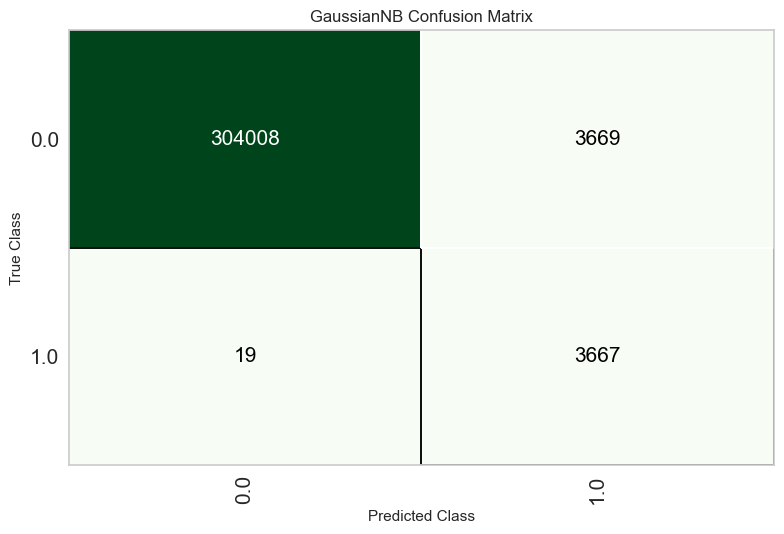

In [16]:
from pycaret.classification import setup, compare_models, plot_model

clf = setup(data=training_data, target="failure")

best_model = compare_models(sort="Recall")  # Sort models by recall
plot_model(best_model, plot="confusion_matrix")

In [17]:
# save the model
import joblib
joblib.dump(best_model, 'best_model_redesigned.joblib')

['best_model_redesigned.joblib']

# Forecasting future measurements using BigQuery ML

In [22]:
cols_names = training_data.columns.tolist()
cols_names.remove("failure")
cols_names

['speed', 'brake', 'temp', 'vibration', 'battery']

In [23]:
def forcast_single_column(bigquery_dataset: str, col_name: str, project_id: str) -> pd.DataFrame:
    """
    Forcasts a single column in {bigquery_dataset}.measurements using BigQuery ML's AI.FORECAST function.
    Returns a DataFrame with columns: id, timestamp, <col_name>
    """
    sql = f"""
        SELECT *
        FROM AI.FORECAST(
            TABLE `{bigquery_dataset}.measurements`,
            data_col => '{col_name}',
            timestamp_col => 'timestamp',
            model => 'TimesFM 2.0',
            id_cols => ['id'],
            horizon => 30,
            confidence_level => .75
        )
    """
    forecast = pd.read_gbq(sql, project_id=project_id, dialect="standard")
    forecast[col_name] = forecast["forecast_value"]
    forecast["timestamp"] = forecast["forecast_timestamp"]
    forecast = forecast[["id", "timestamp", col_name]]
    return forecast

all_forecasts = []
for col_name in cols_names:
    all_forecasts.append(forcast_single_column(bigquery_dataset, col_name, project_id))

In [24]:
# merge all forecasts on id and forecast_timestamp
forecast = all_forecasts[0]
for f in all_forecasts[1:]:
    forecast = forecast.merge(f, on=["id", "timestamp"])

In [25]:
forecast.to_gbq(
    destination_table=f"{bigquery_dataset}.forecast_{TODAY_str}",
    project_id=project_id,
    if_exists="replace"
)

100%|██████████| 1/1 [00:00<?, ?it/s]


In [ ]:
# read forecast table
# forecast = pd.read_gbq(
#     "SELECT * FROM `neuraltwin.wagon_data.forecast`",
#     project_id="neuraltwin",
#     dialect="standard"
# )

In [30]:
forecast

,id,timestamp,speed,brake,temp,vibration,battery
0,WGN-10034,2025-08-22 00:00:00+00:00,59.430405,6.427541,53.951443,2.269228,94.763275
1,WGN-10034,2025-08-23 00:00:00+00:00,59.484379,6.463000,54.007790,2.292742,94.632965
2,WGN-10034,2025-08-24 00:00:00+00:00,59.489147,6.450342,53.898106,2.292933,94.571907
3,WGN-10034,2025-08-25 00:00:00+00:00,59.503761,6.450227,53.924377,2.275686,94.574715
4,WGN-10034,2025-08-26 00:00:00+00:00,59.465919,6.450134,53.973770,2.263528,94.483536
...,...,...,...,...,...,...,...
29785,WGN-99845,2025-09-16 00:00:00+00:00,40.960850,5.166033,45.497559,6.715607,93.645882
29786,WGN-99845,2025-09-17 00:00:00+00:00,40.999531,5.170136,45.563648,6.731823,93.616333
29787,WGN-99845,2025-09-18 00:00:00+00:00,40.912556,5.169646,45.535904,6.739369,93.634872
29788,WGN-99845,2025-09-19 00:00:00+00:00,40.919815,5.164112,45.627659,6.744929,93.649025


# predict failures on forecasted data

In [39]:
from pycaret.classification import predict_model

failure_forecasts = predict_model(best_model, data=forecast.drop(columns=["id", "timestamp"]))
failure_forecasts["id"] = forecast["id"]
failure_forecasts["timestamp"] = forecast["timestamp"]

In [43]:
predicted_failures = failure_forecasts[failure_forecasts["prediction_label"] == 1.0]

In [44]:
predicted_failures.to_gbq(
    destination_table=f"{bigquery_dataset}.predicted_failures_{TODAY_str}",
    project_id=project_id,
    if_exists="replace"
)

100%|██████████| 1/1 [00:00<00:00, 922.84it/s]


# Generate reports

In [51]:
metadata = pd.read_gbq(
    f"SELECT * FROM `{bigquery_dataset}.metadata`",
    project_id=project_id,
    dialect="standard"
)

In [52]:
recent_failures = pd.read_gbq(
    "SELECT * " \
    f"FROM `{bigquery_dataset}.failures` " \
    f"WHERE timestamp >= TIMESTAMP_SUB(TIMESTAMP('{TODAY}'), INTERVAL 30 DAY)",
    project_id=project_id,
    dialect="standard"
)

In [53]:
recent_measurements = pd.read_gbq(
    "SELECT * " \
    f"FROM `{bigquery_dataset}.measurements` " \
    f"WHERE timestamp >= TIMESTAMP_SUB(TIMESTAMP('{TODAY}'), INTERVAL 30 DAY)",
    project_id=project_id,
    dialect="standard"
)

In [54]:
pdf_report_receiver = "Operator"

In [56]:
enriched_recent_failures = recent_failures.merge(metadata, on="id", how="left")
enriched_recent_failures

def generate_failure_json_summary_for_report(df: pd.DataFrame) -> dict:
    summary = {
        "n_recent_failures": len(df),
        "n_percentage_failed": (len(df) / df["id"].nunique()) * 100 if df["id"].nunique() > 0 else 0,
        "n_failures_by_type": df["failure_type"].value_counts().to_dict() if "failure_type" in df.columns else {},
        "failure_ids": df["id"].tolist(),
        "failure_details": df.to_dict(orient="records")
    }
    return summary

failure_details_for_report = (
    enriched_recent_failures
    .groupby(pdf_report_receiver)
    .apply(generate_failure_json_summary_for_report)
)
failure_details_for_report

Operator
Dawson-Cox                      {'n_recent_failures': 63, 'n_percentage_failed...
Fisher LLC                      {'n_recent_failures': 38, 'n_percentage_failed...
Galvan PLC                      {'n_recent_failures': 41, 'n_percentage_failed...
Goodman and Sons                {'n_recent_failures': 42, 'n_percentage_failed...
Gould, Peters and Mckee         {'n_recent_failures': 35, 'n_percentage_failed...
Hall-Brewer                     {'n_recent_failures': 33, 'n_percentage_failed...
Martinez, Robinson and White    {'n_recent_failures': 38, 'n_percentage_failed...
Mendoza, Mercado and Stanley    {'n_recent_failures': 50, 'n_percentage_failed...
Novak-Hall                      {'n_recent_failures': 39, 'n_percentage_failed...
Richardson LLC                  {'n_recent_failures': 48, 'n_percentage_failed...
Rubio, Griffith and Watkins     {'n_recent_failures': 55, 'n_percentage_failed...
Smith Ltd                       {'n_recent_failures': 45, 'n_percentage_failed...
Thornto

In [57]:
enriched_recent_measurements = recent_measurements.merge(metadata, on="id", how="left")
measurement_details_for_report = (
    enriched_recent_measurements
    .groupby(pdf_report_receiver)
    .apply(lambda df: df.describe().to_dict())
)
measurement_details_for_report

Operator
Dawson-Cox                      {'speed': {'count': 3700.0, 'mean': 45.2385804...
Fisher LLC                      {'speed': {'count': 2900.0, 'mean': 47.6281638...
Galvan PLC                      {'speed': {'count': 3450.0, 'mean': 45.9936266...
Goodman and Sons                {'speed': {'count': 3550.0, 'mean': 48.4204385...
Gould, Peters and Mckee         {'speed': {'count': 3300.0, 'mean': 47.0115096...
Hall-Brewer                     {'speed': {'count': 2800.0, 'mean': 47.0319713...
Martinez, Robinson and White    {'speed': {'count': 3100.0, 'mean': 48.0650433...
Mendoza, Mercado and Stanley    {'speed': {'count': 3450.0, 'mean': 47.5717376...
Novak-Hall                      {'speed': {'count': 3400.0, 'mean': 47.1507211...
Richardson LLC                  {'speed': {'count': 3700.0, 'mean': 46.8879473...
Rubio, Griffith and Watkins     {'speed': {'count': 4100.0, 'mean': 49.3961770...
Smith Ltd                       {'speed': {'count': 3400.0, 'mean': 46.9827314...
Thornto

In [58]:
enriched_predicted_failures = predicted_failures.merge(metadata, on="id", how="left")
predicted_failures_for_report = (
    enriched_predicted_failures
    .groupby(pdf_report_receiver)
    .apply(lambda df: df.to_dict())
)
predicted_failures_for_report

Operator
Smith Ltd    {'speed': {0: 11.007293701171875}, 'brake': {0...
dtype: object

In [59]:
details_for_report = pd.DataFrame(
    {
        "failure_details": failure_details_for_report,
        "measurement_details": measurement_details_for_report,
        "predicted_failures": predicted_failures_for_report,
    }
)
details_for_report.reset_index(inplace=True)
details_for_report

,Operator,failure_details,measurement_details,predicted_failures
0,Dawson-Cox,"{'n_recent_failures': 63, 'n_percentage_failed...","{'speed': {'count': 3700.0, 'mean': 45.2385804...",NaN
1,Fisher LLC,"{'n_recent_failures': 38, 'n_percentage_failed...","{'speed': {'count': 2900.0, 'mean': 47.6281638...",NaN
2,Galvan PLC,"{'n_recent_failures': 41, 'n_percentage_failed...","{'speed': {'count': 3450.0, 'mean': 45.9936266...",NaN
3,Goodman and Sons,"{'n_recent_failures': 42, 'n_percentage_failed...","{'speed': {'count': 3550.0, 'mean': 48.4204385...",NaN
4,"Gould, Peters and Mckee","{'n_recent_failures': 35, 'n_percentage_failed...","{'speed': {'count': 3300.0, 'mean': 47.0115096...",NaN
5,Hall-Brewer,"{'n_recent_failures': 33, 'n_percentage_failed...","{'speed': {'count': 2800.0, 'mean': 47.0319713...",NaN
6,"Martinez, Robinson and White","{'n_recent_failures': 38, 'n_percentage_failed...","{'speed': {'count': 3100.0, 'mean': 48.0650433...",NaN
7,"Mendoza, Mercado and Stanley","{'n_recent_failures': 50, 'n_percentage_failed...","{'speed': {'count': 3450.0, 'mean': 47.5717376...",NaN
8,Novak-Hall,"{'n_recent_failures': 39, 'n_percentage_failed...","{'speed': {'count': 3400.0, 'mean': 47.1507211...",NaN
9,Richardson LLC,"{'n_recent_failures': 48, 'n_percentage_failed...","{'speed': {'count': 3700.0, 'mean': 46.8879473...",NaN


In [64]:
details_for_report["prompt"] = details_for_report.apply(lambda row: f"""
Create an HTML report for IIoT sensor data and failures for {row[pdf_report_receiver]} with four sections.
In a first section, provide a written a summary of the most important overall details using only text.
In the second section, provide a summary paragraph and a table for details on failures.
In the third section, summarize measurements details first in a written paragraph and then in a table.
In the fourth section, summarize predicted failures first in a written paragraph, but do not include a table.
If there are no predicted failures, state that there are no predicted failures.
In the Make sure the report looks professional when viewed in a web browser.
Also, don't include anything unnecessary like descriptions of how you have created the report or newline symbols.
Here is the json summary of the recent data:
- Failure Details: {row['failure_details']}
- Measurement Details: {row['measurement_details']}
- Predicted Failure Details: {row['predicted_failures']}
""", axis=1)
details_for_report

,Operator,failure_details,measurement_details,predicted_failures,prompt
0,Dawson-Cox,"{'n_recent_failures': 63, 'n_percentage_failed...","{'speed': {'count': 3700.0, 'mean': 45.2385804...",NaN,\nCreate an HTML report for IIoT sensor data a...
1,Fisher LLC,"{'n_recent_failures': 38, 'n_percentage_failed...","{'speed': {'count': 2900.0, 'mean': 47.6281638...",NaN,\nCreate an HTML report for IIoT sensor data a...
2,Galvan PLC,"{'n_recent_failures': 41, 'n_percentage_failed...","{'speed': {'count': 3450.0, 'mean': 45.9936266...",NaN,\nCreate an HTML report for IIoT sensor data a...
3,Goodman and Sons,"{'n_recent_failures': 42, 'n_percentage_failed...","{'speed': {'count': 3550.0, 'mean': 48.4204385...",NaN,\nCreate an HTML report for IIoT sensor data a...
4,"Gould, Peters and Mckee","{'n_recent_failures': 35, 'n_percentage_failed...","{'speed': {'count': 3300.0, 'mean': 47.0115096...",NaN,\nCreate an HTML report for IIoT sensor data a...
5,Hall-Brewer,"{'n_recent_failures': 33, 'n_percentage_failed...","{'speed': {'count': 2800.0, 'mean': 47.0319713...",NaN,\nCreate an HTML report for IIoT sensor data a...
6,"Martinez, Robinson and White","{'n_recent_failures': 38, 'n_percentage_failed...","{'speed': {'count': 3100.0, 'mean': 48.0650433...",NaN,\nCreate an HTML report for IIoT sensor data a...
7,"Mendoza, Mercado and Stanley","{'n_recent_failures': 50, 'n_percentage_failed...","{'speed': {'count': 3450.0, 'mean': 47.5717376...",NaN,\nCreate an HTML report for IIoT sensor data a...
8,Novak-Hall,"{'n_recent_failures': 39, 'n_percentage_failed...","{'speed': {'count': 3400.0, 'mean': 47.1507211...",NaN,\nCreate an HTML report for IIoT sensor data a...
9,Richardson LLC,"{'n_recent_failures': 48, 'n_percentage_failed...","{'speed': {'count': 3700.0, 'mean': 46.8879473...",NaN,\nCreate an HTML report for IIoT sensor data a...


In [69]:
details_for_report_table_name = f"{bigquery_dataset}.details_for_report_{TODAY_str}"
details_for_report[[pdf_report_receiver, "prompt"]].to_gbq(
    destination_table=details_for_report_table_name,
    project_id=project_id,
    if_exists="replace"
)

100%|██████████| 1/1 [00:00<?, ?it/s]


In [70]:
query = f"""SELECT
  {pdf_report_receiver},
  AI.GENERATE(
    ('', prompt),
    connection_id => 'projects/neuraltwin/locations/eu/connections/vertex-ai-connecton-neuraltwin',
    endpoint => 'gemini-2.0-flash-lite'
  ).result AS report
FROM
  `{details_for_report_table_name}`;
"""
reports = bigquery_client.query(query).to_dataframe()

In [71]:
reports.to_gbq(
    destination_table=f"{bigquery_dataset}.html_reports_{TODAY_str}",
    project_id=project_id,
    if_exists="replace"
)

100%|██████████| 1/1 [00:00<?, ?it/s]


In [73]:
reports

,Operator,report
0,Richardson LLC,```html\n<!DOCTYPE html>\n<html>\n<head>\n<tit...
1,Galvan PLC,"```html\n<!DOCTYPE html>\n<html lang=""en"">\n<h..."
2,"Gould, Peters and Mckee",```html\n<!DOCTYPE html>\n<html>\n<head>\n<tit...
3,Webster-Moore,```html\n<!DOCTYPE html>\n<html>\n<head>\n<tit...
4,Fisher LLC,<!DOCTYPE html>\n<html>\n<head>\n<title>IIoT S...
5,"Martinez, Robinson and White",```html\n<!DOCTYPE html>\n<html>\n<head>\n<tit...
6,Novak-Hall,```html\n<!DOCTYPE html>\n<html>\n<head>\n<tit...
7,"Wilson, Campbell and Lewis",```html\n<!DOCTYPE html>\n<html>\n<head>\n<tit...
8,Hall-Brewer,```html\n<!DOCTYPE html>\n<html>\n<head>\n<tit...
9,Smith Ltd,<!DOCTYPE html>\n<html>\n<head>\n<title>IIoT S...
